In [1]:
# After the installation is done please restart the colab kernel for it to pick up new packages
# No need to rerun this cell after kernel restart
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1

!pip3 install box2d-py
!pip3 install gym[Box_2D]
!pip install -U colabgymrender
!pip install neptune-client 
!pip install -e git+https://github.com/awarelab/spinningup_tf2.git#egg=spinup_bis

     |████████████████████████████████| 448 kB 5.3 MB/s 
     |████████████████████████████████| 316 kB 5.1 MB/s 
     |████████████████████████████████| 829 kB 41.0 MB/s 
     |████████████████████████████████| 54 kB 2.5 MB/s 
     |████████████████████████████████| 181 kB 28.3 MB/s 
     |████████████████████████████████| 132 kB 51.7 MB/s 
     |████████████████████████████████| 79 kB 7.6 MB/s 
     |████████████████████████████████| 8.7 MB 34.6 MB/s 
     |████████████████████████████████| 138 kB 44.6 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 127 kB 45.4 MB/s 
     |████████████████████████████████| 67 kB 5.4 MB/s 
     |████████████████████████████████| 130 kB 50.1 MB/s 
     |████████████████████████████████| 64 kB 2.5 MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.16.0-py2.py3-none-any.whl size=565726 sha256=881ae429d3284fdc245c23883cc3eee56277f08e26cb67866b325f012367fdf5
  Stored in directory: /root

# The Code of VPG & PPO

In [1]:
# If this import fails please restart the runtime
import spinup_bis

In [2]:
import abc
import random
import time

import numpy as np
import tensorflow as tf

import spinup_bis
from spinup_bis.algos.tf2.vpg import core
from spinup_bis.utils import logx

In [3]:
class Buffer:
    """A buffer for storing trajectories experienced by a VPG agent.

    Uses Generalized Advantage Estimation (GAE-Lambda) for calculating
    the advantages of state-action pairs.
    """

    def __init__(self, obs_dim, act_dim, size, gamma=0.99, lam=0.95):
        self.obs_buf = np.zeros(core.combined_shape(size, obs_dim),
                                dtype=np.float32)
        self.act_buf = np.zeros(core.combined_shape(size, act_dim),
                                dtype=np.float32)
        self.adv_buf = np.zeros(size, dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.ret_buf = np.zeros(size, dtype=np.float32)
        self.val_buf = np.zeros(size, dtype=np.float32)
        self.logp_buf = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.ptr, self.path_start_idx, self.max_size = 0, 0, size

    def store(self, obs, act, rew, val, logp):
        """Append one timestep of agent-environment interaction to the buffer.
        """
        assert self.ptr < self.max_size  # buffer has to have room
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.val_buf[self.ptr] = val
        self.logp_buf[self.ptr] = logp
        self.ptr += 1

    def finish_path(self, last_val=0):
        """Computes reward for unfinished trajectory.

        Call this at the end of a trajectory, or when one gets cut off
        by an epoch ending. This looks back in the buffer to where the
        trajectory started, and uses rewards and value estimates from
        the whole trajectory to compute advantage estimates with GAE-Lambda,
        as well as compute the rewards-to-go for each state, to use as
        the targets for the value function.
        The "last_val" argument should be 0 if the trajectory ended
        because the agent reached a terminal state (died), and otherwise
        should be V(s_T), the value function estimated for the last state.
        This allows us to bootstrap the reward-to-go calculation to account
        for timesteps beyond the arbitrary episode horizon (or epoch cutoff).
        """

        path_slice = slice(self.path_start_idx, self.ptr)
        rews = np.append(self.rew_buf[path_slice], last_val)
        vals = np.append(self.val_buf[path_slice], last_val)

        # the next two lines implement GAE-Lambda advantage calculation
        deltas = rews[:-1] + self.gamma * vals[1:] - vals[:-1]
        self.adv_buf[path_slice] = \
            core.discount_cumsum(deltas, self.gamma * self.lam)

        # the next line computes rewards-to-go, targets for the value function
        self.ret_buf[path_slice] = core.discount_cumsum(rews, self.gamma)[:-1]

        self.path_start_idx = self.ptr

    def get(self):
        """Returns data stored in buffer.

        Call this at the end of an epoch to get all of the data from
        the buffer, with advantages appropriately normalized (shifted to have
        mean zero and std one). Also, resets some pointers in the buffer.
        """
        assert self.ptr == self.max_size  # buffer has to be full
        self.ptr, self.path_start_idx = 0, 0
        # the next two lines implement the advantage normalization trick
        adv_mean, adv_std = self.adv_buf.mean(), self.adv_buf.std()
        self.adv_buf = (self.adv_buf - adv_mean) / adv_std
        return [self.obs_buf, self.act_buf, self.adv_buf,
                self.ret_buf, self.logp_buf]

In [4]:
class PolicyGradientAlgorithm(abc.ABC):
    def __init__(self, env_fn, actor_critic=core.mlp_actor_critic, ac_kwargs=None, seed=0,
            total_steps=int(1e6), train_every=4000, log_every=4000, gamma=0.99,
            pi_lr=3e-4, v_lr=1e-3, train_v_iters=80, lam=0.97, max_ep_len=1000,
            logger_kwargs=None):
        """Vanilla Policy Gradient with GAE-Lambda for advantage estimation.

        Args:
            env_fn : A function which creates a copy of the environment.
                The environment must satisfy the OpenAI Gym API.

            actor_critic: A function which takes in `action_space` and
                `observation_space` kwargs, and returns actor and critic
                tf.keras.Model-s.

            ac_kwargs (dict): Any kwargs appropriate for the actor_critic
                function you provided to VPG.

            seed (int): Seed for random number generators.

            total_steps (int): Number of environment interactions to run and train
                the agent.

            train_every (int): Number of environment interactions that should elapse
                between training epochs.

            log_every (int): Number of environment interactions that should elapse
                between dumping logs.

            gamma (float): Discount factor. (Always between 0 and 1.)

            pi_lr (float): Learning rate for policy optimizer.

            v_lr (float): Learning rate for value function optimizer.

            train_v_iters (int): Number of gradient descent steps to take on
                value function per epoch.

            lam (float): Lambda for GAE-Lambda. (Always between 0 and 1,
                close to 1.)

            max_ep_len (int): Maximum length of trajectory / episode / rollout.

            logger_kwargs (dict): Keyword args for EpochLogger.
        """
        params_to_save = locals()
        self.logger = logx.EpochLogger(**(logger_kwargs or {}))
        self.logger.save_config(params_to_save)

        random.seed(seed)
        tf.random.set_seed(seed)
        np.random.seed(seed)

        # In case of distributed computations these values have to be updated
        self.total_steps = total_steps
        self.train_every = train_every
        self.log_every = log_every
        self.max_ep_len = max_ep_len
        self.train_v_iters = train_v_iters

        self.env = env_fn()
        obs_dim = np.prod(self.env.observation_space.shape)
        act_dim = self.env.action_space.shape
        self.env.seed(seed)

        self.replay_buffer = Buffer(obs_dim=obs_dim, act_dim=act_dim,
                                size=train_every, gamma=gamma, lam=lam)

        ac_kwargs = ac_kwargs or {}
        ac_kwargs['observation_space'] = self.env.observation_space
        ac_kwargs['action_space'] = self.env.action_space

        self.actor, self.critic = actor_critic(**ac_kwargs)

        self.actor.build(input_shape=(None, obs_dim))
        self.critic.build(input_shape=(None, obs_dim))

        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=pi_lr)
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=v_lr)

    @tf.function
    def value(self, observations):
        return self.critic(observations)

    def get_value(self, observation):
        return self.value(np.array([observation])).numpy()[0]

    @tf.function
    def value_loss(self, observations, rtg):
        return tf.reduce_mean((self.critic(observations) - rtg) ** 2)

    @tf.function
    def value_train_step(self, observations, rtg):
        def loss():
            return self.value_loss(observations, rtg)

        self.critic_optimizer.minimize(loss, self.critic.trainable_variables)

        return loss()

    def get_action(self, observation):
        return self.actor.action(np.array([observation])).numpy()[0]

    @tf.function
    def pi_train_step(self, observations, actions, advantages, logp_old):
        def loss():
            logp = self.actor.action_logprob(observations, actions)
            return self.pi_loss(logp, logp_old, advantages)

        self.actor_optimizer.minimize(loss, self.actor.trainable_variables)

        # For logging purposes
        logp = self.actor.action_logprob(observations, actions)
        loss_new = self.pi_loss(logp, logp_old, advantages)

        return loss_new, tf.reduce_mean(logp_old - logp), tf.reduce_mean(-logp)

    def run(self):
        start_time = time.time()
        obs, ep_ret, ep_len = self.env.reset(), 0, 0

        # Main loop: collect experience in env and update/log each epoch
        for t in range(self.total_steps):
            action = self.get_action(obs)
            v_t = self.get_value(obs)
            logp = self.actor.action_logprob(np.array([obs]),
                                        np.array([action])).numpy()[0]

            # Step the env
            new_obs, rew, done, _ = self.env.step(action)
            ep_ret += rew
            ep_len += 1

            # Ignore the "done" signal if it comes from hitting the time
            # horizon (that is, when it's an artificial terminal signal
            # that isn't based on the agent's state)
            done = False if ep_len == self.max_ep_len else done

            # Store experience to replay buffer
            self.replay_buffer.store(obs, action, rew, v_t, logp)
            self.logger.store(VVals=v_t)

            # Super critical, easy to overlook step: make sure to update
            # most recent observation!
            obs = new_obs

            # End of trajectory handling
            if done or (ep_len == self.max_ep_len):
                self.logger.store(EpRet=ep_ret, EpLen=ep_len)

            if done or (ep_len == self.max_ep_len) or (t + 1) % self.train_every == 0:
                obs, ep_ret, ep_len = self.env.reset(), 0, 0

                # if trajectory didn't reach terminal state, bootstrap value target
                last_val = 0 if done else self.get_value(obs)
                self.replay_buffer.finish_path(last_val)

            # Update handling
            if (t + 1) % self.train_every == 0:
                self.do_update()

            # End of epoch wrap-up
            if ((t + 1) % self.log_every == 0) or (t + 1 == self.total_steps):
                # Log info about epoch
                self.logger.log_tabular('EpRet', with_min_and_max=True)
                self.logger.log_tabular('EpLen', average_only=True)
                self.logger.log_tabular('VVals', with_min_and_max=True)
                self.logger.log_tabular('LossV', average_only=True)
                self.logger.log_tabular('LossPi', average_only=True)
                self.logger.log_tabular('Entropy', average_only=True)
                self.logger.log_tabular('KL', average_only=True)
                self.logger.log_tabular('TotalEnvInteracts', (t + 1))
                self.logger.log_tabular('Time', time.time() - start_time)
                self.logger.dump_tabular()

    @abc.abstractmethod
    def do_update(self):
        pass


    @abc.abstractmethod
    def pi_loss(self, logp, advantages):
        pass

# Exercise
Please fill in missing pieces of code marked:
```
###### TODO ######
<Descritpion>
#-----------------

###### END  ######

```

In [19]:
class VPG(PolicyGradientAlgorithm):
    def do_update(self):
        [batch_obs, batch_act, batch_adv, batch_rtg,
        batch_logp] = self.replay_buffer.get()

        loss, kl, entropy = self.pi_train_step(batch_obs, batch_act,
                                        batch_adv, batch_logp)
        self.logger.store(LossPi=loss.numpy(), KL=kl.numpy(),
                    Entropy=entropy.numpy())

        for _ in range(self.train_v_iters):
            loss = self.value_train_step(batch_obs, batch_rtg)
            self.logger.store(LossV=loss)

    @tf.function
    def pi_loss(self, logp, _logp_old, advantages):
        ###### TODO ######
        # Implement pi loss calcualation 
        #-----------------
        loss = -tf.reduce_mean(logp * advantages)
        ###### END  ######
        return loss


class PPO(PolicyGradientAlgorithm):
    def __init__(self, clip_ratio=0.2, train_pi_iters=80, target_kl=0.01, **kwargs):
        super(PPO, self).__init__(**kwargs)
        self.clip_ratio = clip_ratio
        self.train_pi_iters = train_pi_iters
        self.target_kl = target_kl

    def do_update(self):
        [batch_obs, batch_act, batch_adv, batch_rtg,
            batch_logp] = self.replay_buffer.get()

        for i in range(self.train_pi_iters):
            loss, kl, entropy = self.pi_train_step(batch_obs, batch_act,
                                                batch_adv, batch_logp)
            self.logger.store(LossPi=loss.numpy(), KL=kl.numpy(),
                            Entropy=entropy.numpy())
            
            ###### TODO ######
            # Implement early stopping of pi training based on kl value
            # Log step at which you break the loop using self.logger.log method
            #-----------------
            if kl > self.target_kl:
                self.logger.log('Early stopping at step {}'.format(i))
                break
            ###### END  ######

        for _ in range(self.train_v_iters):
            loss = self.value_train_step(batch_obs, batch_rtg)
            self.logger.store(LossV=loss)

    @tf.function
    def pi_loss(self, logp, logp_old, advantages):
        ###### TODO ######
        # Implement pi loss calcualation
        #-----------------
        ratio = tf.exp(logp - logp_old)
        clip_ratio = tf.clip_by_value(ratio, 1 - self.clip_ratio, 1 + self.clip_ratio)
        loss = -tf.reduce_mean(tf.minimum(ratio * advantages, clip_ratio * advantages))
        ###### END  ######
        return loss 

# Lets test the solution - train the agents

## First sanity check on CartPole
If your implementation cannot reach the goals specified below you might have some bug in your code.

In [20]:
import gym

from spinup_bis.algos.tf2.vpg.core import mlp_actor_critic
from spinup_bis import ppo_tf2 as PPO_org

def env_fn():
    env = gym.make("CartPole-v1")
    return env

In [21]:
# VPG should reach performance over 100 with this setting 
vpg = VPG(env_fn=env_fn, actor_critic=mlp_actor_critic, total_steps=int(5e+4), v_lr=0.001, pi_lr=0.0003, train_every=500, max_ep_len=500, logger_kwargs={"output_dir": "./logs/vpg"})
vpg.run()

Logging data to ./logs/vpg/progress.txt
Saving config:

{
    "ac_kwargs":	null,
    "actor_critic":	"mlp_actor_critic",
    "env_fn":	"env_fn",
    "gamma":	0.99,
    "lam":	0.97,
    "log_every":	4000,
    "logger_kwargs":	{
        "output_dir":	"./logs/vpg"
    },
    "max_ep_len":	500,
    "pi_lr":	0.0003,
    "seed":	0,
    "self":	{
        "<__main__.VPG object at 0x7f6a3e341450>":	{
            "logger":	{
                "<spinup_bis.utils.logx.EpochLogger object at 0x7f6a3e341a50>":	{
                    "epoch_dict":	{},
                    "exp_name":	null,
                    "first_row":	true,
                    "log_current_row":	{},
                    "log_headers":	[],
                    "neptune_run":	null,
                    "output_dir":	"./logs/vpg",
                    "output_file":	{
                        "<_io.TextIOWrapper name='./logs/vpg/progress.txt' mode='w' encoding='UTF-8'>":	{
                            "mode":	"w"
                        }
    

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|      AverageEpRet |            25.9 |
|          StdEpRet |            15.5 |
|          MaxEpRet |              98 |
|          MinEpRet |               8 |
|             EpLen |            25.9 |
|      AverageVVals |            11.4 |
|          StdVVals |            6.11 |
|          MaxVVals |            18.7 |
|          MinVVals |           -11.7 |
|             LossV |             157 |
|            LossPi |         -0.0137 |
|           Entropy |           0.688 |
|                KL |        6.51e-05 |
| TotalEnvInteracts |           4e+03 |
|              Time |            18.3 |
---------------------------------------
---------------------------------------
|      AverageEpRet |            31.5 |
|          StdEpRet |            19.9 |
|          MaxEpRet |             108 |
|          MinEpRet |               8 |
|             EpLen |            31.5 |
|      AverageVVals |            18.8 |
|          StdVVals |            5.67 |


In [22]:
# PPO should reach performance around 500 with this setting
ppo = PPO(env_fn=env_fn, actor_critic=mlp_actor_critic, total_steps=int(5e+4), v_lr=0.001, pi_lr=0.0003, train_every=500, max_ep_len=500, logger_kwargs={"output_dir": "./logs/ppo"})
ppo.run()

Logging data to ./logs/ppo/progress.txt
Saving config:

{
    "ac_kwargs":	null,
    "actor_critic":	"mlp_actor_critic",
    "env_fn":	"env_fn",
    "gamma":	0.99,
    "lam":	0.97,
    "log_every":	4000,
    "logger_kwargs":	{
        "output_dir":	"./logs/ppo"
    },
    "max_ep_len":	500,
    "pi_lr":	0.0003,
    "seed":	0,
    "self":	{
        "<__main__.PPO object at 0x7f6ab0095cd0>":	{
            "logger":	{
                "<spinup_bis.utils.logx.EpochLogger object at 0x7f6a3e2cd190>":	{
                    "epoch_dict":	{},
                    "exp_name":	null,
                    "first_row":	true,
                    "log_current_row":	{},
                    "log_headers":	[],
                    "neptune_run":	null,
                    "output_dir":	"./logs/ppo",
                    "output_file":	{
                        "<_io.TextIOWrapper name='./logs/ppo/progress.txt' mode='w' encoding='UTF-8'>":	{
                            "mode":	"w"
                        }
    

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Early stopping at step 13
Early stopping at step 11
Early stopping at step 7
Early stopping at step 13
Early stopping at step 6
Early stopping at step 21
---------------------------------------
|      AverageEpRet |            47.2 |
|          StdEpRet |            37.5 |
|          MaxEpRet |             225 |
|          MinEpRet |              11 |
|             EpLen |            47.2 |
|      AverageVVals |              16 |
|          StdVVals |            9.99 |
|          MaxVVals |            31.4 |
|          MinVVals |           -16.3 |
|             LossV |             475 |
|            LossPi |         -0.0107 |
|           Entropy |           0.647 |
|                KL |         0.00308 |
| TotalEnvInteracts |           4e+03 |
|              Time |            18.2 |
---------------------------------------
Early stopping at step 6
---------------------------------------
|      AverageEpRet |             240 |
|          StdEpRet |             126 |
|          MaxEpRet |

## Now lets learn more difficult task

In [23]:
def env_fn():
    env = gym.make("BipedalWalker-v3")
    return env

In [24]:
vpg = VPG(env_fn=env_fn, actor_critic=mlp_actor_critic, total_steps=int(5e+5), v_lr=0.001, pi_lr=0.0003, train_every=1000, logger_kwargs={"output_dir": "./logs/vpg"})
vpg.run()

Logging data to ./logs/vpg/progress.txt
Saving config:

{
    "ac_kwargs":	null,
    "actor_critic":	"mlp_actor_critic",
    "env_fn":	"env_fn",
    "gamma":	0.99,
    "lam":	0.97,
    "log_every":	4000,
    "logger_kwargs":	{
        "output_dir":	"./logs/vpg"
    },
    "max_ep_len":	1000,
    "pi_lr":	0.0003,
    "seed":	0,
    "self":	{
        "<__main__.VPG object at 0x7f6a3df71710>":	{
            "logger":	{
                "<spinup_bis.utils.logx.EpochLogger object at 0x7f6a3df71450>":	{
                    "epoch_dict":	{},
                    "exp_name":	null,
                    "first_row":	true,
                    "log_current_row":	{},
                    "log_headers":	[],
                    "neptune_run":	null,
                    "output_dir":	"./logs/vpg",
                    "output_file":	{
                        "<_io.TextIOWrapper name='./logs/vpg/progress.txt' mode='w' encoding='UTF-8'>":	{
                            "mode":	"w"
                        }
   

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|      AverageEpRet |           -82.6 |
|          StdEpRet |            24.1 |
|          MaxEpRet |           -57.4 |
|          MinEpRet |            -115 |
|             EpLen |             628 |
|      AverageVVals |           -4.36 |
|          StdVVals |            2.67 |
|          MaxVVals |            1.25 |
|          MinVVals |            -7.4 |
|             LossV |             170 |
|            LossPi |          0.0245 |
|           Entropy |            3.69 |
|                KL |           0.006 |
| TotalEnvInteracts |           4e+03 |
|              Time |            20.2 |
---------------------------------------
---------------------------------------
|      AverageEpRet |           -63.5 |
|          StdEpRet |            1.64 |
|          MaxEpRet |           -61.4 |
|          MinEpRet |           -65.3 |
|             EpLen |           1e+03 |
|      AverageVVals |           -7.39 |
|          StdVVals |            1.62 |


In [25]:
ppo = PPO(env_fn=env_fn, actor_critic=mlp_actor_critic,  total_steps=int(5e+5), v_lr=0.001, pi_lr=0.0003, train_every=1000, logger_kwargs={"output_dir": "./logs/ppo"})
ppo.run()

Logging data to ./logs/ppo/progress.txt
Saving config:

{
    "ac_kwargs":	null,
    "actor_critic":	"mlp_actor_critic",
    "env_fn":	"env_fn",
    "gamma":	0.99,
    "lam":	0.97,
    "log_every":	4000,
    "logger_kwargs":	{
        "output_dir":	"./logs/ppo"
    },
    "max_ep_len":	1000,
    "pi_lr":	0.0003,
    "seed":	0,
    "self":	{
        "<__main__.PPO object at 0x7f6a3e297ed0>":	{
            "logger":	{
                "<spinup_bis.utils.logx.EpochLogger object at 0x7f6a3e297650>":	{
                    "epoch_dict":	{},
                    "exp_name":	null,
                    "first_row":	true,
                    "log_current_row":	{},
                    "log_headers":	[],
                    "neptune_run":	null,
                    "output_dir":	"./logs/ppo",
                    "output_file":	{
                        "<_io.TextIOWrapper name='./logs/ppo/progress.txt' mode='w' encoding='UTF-8'>":	{
                            "mode":	"w"
                        }
   

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Early stopping at step 0
Early stopping at step 2
Early stopping at step 2
---------------------------------------
|      AverageEpRet |           -85.4 |
|          StdEpRet |            23.8 |
|          MaxEpRet |           -57.4 |
|          MinEpRet |            -112 |
|             EpLen |             531 |
|      AverageVVals |           -4.82 |
|          StdVVals |            3.17 |
|          MaxVVals |            1.25 |
|          MinVVals |           -11.3 |
|             LossV |             150 |
|            LossPi |         -0.0171 |
|           Entropy |            3.71 |
|                KL |         0.00421 |
| TotalEnvInteracts |           4e+03 |
|              Time |            20.6 |
---------------------------------------
Early stopping at step 2
Early stopping at step 14
Early stopping at step 50
Early stopping at step 4
---------------------------------------
|      AverageEpRet |           -89.8 |
|          StdEpRet |            21.6 |
|          MaxEpRet |  

# Visualize learned policy

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
from colabgymrender.recorder import Recorder
from pyvirtualdisplay import Display

display = Display(visible=0, size=(400, 300))
display.start()

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2310144/45929032 bytes (5.0%)5808128/45929032 bytes (12.6%)9314304/45929032 bytes (20.3%)12591104/45929032 bytes (27.4%)16162816/45929032 bytes (35.2%)19619840/45929032 bytes (42.7%)23134208/45929032 bytes (50.4%)26714112/45929032 bytes (58.2%)30089216/45929032 bytes (65.5%)33726464/45929032 bytes (73.4%)37273600/45929032 bytes (81.2%)40927232/45929032 bytes (89.1%)

In [27]:
def test_agent(actor):
    NUM_TEST_RUNS = 10
    env = gym.make("BipedalWalker-v3")

    performance = []
    for _ in range(NUM_TEST_RUNS):
        done = False
        obs = env.reset()
        ep_reward = 0
        while not done:
            action = actor(tf.expand_dims(obs, axis=0))[0]
            obs, reward, done, info = env.step(action.numpy()[0])
            ep_reward += reward
        performance.append(ep_reward)

    env = gym.make("BipedalWalker-v3")
    env = Recorder(env, "./videos")
    obs = env.reset()
    while True:
        action = actor(tf.expand_dims(obs, axis=0))[0]
        obs, reward, done, info = env.step(action.numpy()[0])

        if done:
            break

    env.release()
    env.play()

    return np.asarray(performance)

In [28]:
vpg_performance = test_agent(vpg.actor)

In [29]:
ppo_performance = test_agent(ppo.actor)

# Evaluate performance

In [30]:
vpg_data = pd.read_csv("./logs/vpg/progress.txt", delimiter="\t")
ppo_data = pd.read_csv("./logs/ppo/progress.txt", delimiter="\t")

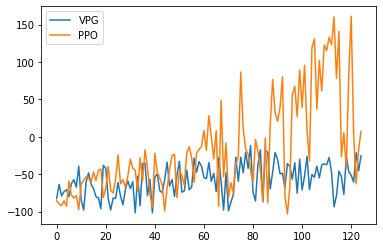

In [31]:
plt.plot(vpg_data["AverageEpRet"], label="VPG")
plt.plot(ppo_data["AverageEpRet"], label="PPO")
plt.legend()
plt.show()

<BarContainer object of 2 artists>

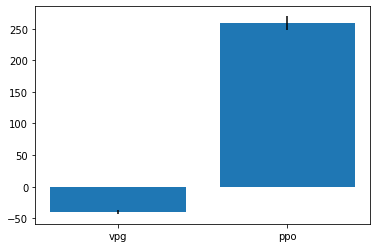

In [32]:
plt.bar(["vpg", "ppo"], [vpg_performance.mean(), ppo_performance.mean()], yerr=[vpg_performance.std(), ppo_performance.std()])